/home/liyiming/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1699: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Finished reading the train set of Leaves Dataset (18353 samples found)
Training for fold 0/10...
loaded model from ../models/fold=0-model.pth for resume training with current_epoch=0
Epoch 0/100 training...


  0%|          | 0/130 [00:00<?, ?it/s]

9/130 loss:2.6570934772491457  acc:0.26953125
19/130 loss:2.63609756231308  acc:0.275390625


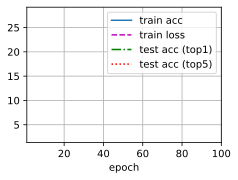

29/130 loss:2.573922944068909  acc:0.28515625


In [ ]:
from train import train

args = {
    'batch_size': 128,
    'model': 'seresnext50',
    'freeze': False,
    'eval_all': True,
    'data_root': '../dataset/classify-leaves',
    'val_ratio': 0.1,
    'fold': 10,
    'lr': 0.01,
    'epoch': 100,
    'resume': True,
    'verbose': True,
    'ckpt_path': 'model.pth'
}
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
args = AttributeDict(args)

train(args)